## Временной ряд: Monthly critical radio frequencies in Washington, D.C., May 1934 – April 1954. These frequencies reflect the highest radio frequency that can be used for broadcasting

Нужно сделать предсказания на 3 года

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/home/alex/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data = pd.read_csv('monthly-critical-radio-frequenci.csv',index_col=['month'], parse_dates=['month'], dayfirst=True)

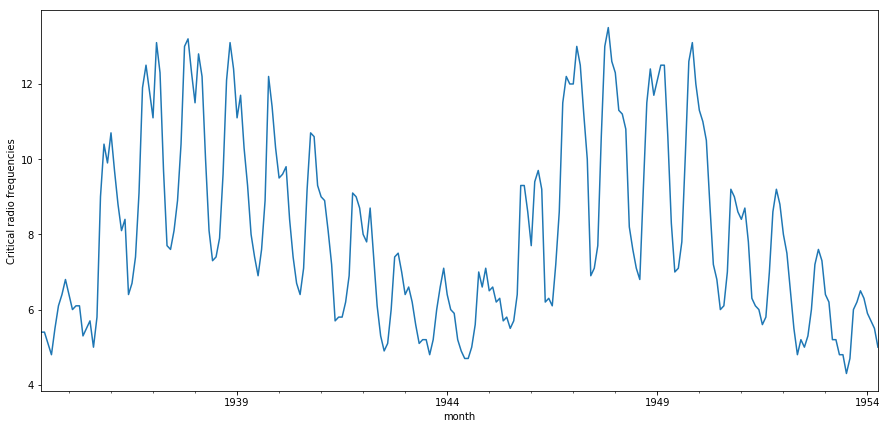

In [3]:
figsize(15,7)
data.rad_freq.plot()
plt.ylabel('Critical radio frequencies')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

## Важно:
В этом временном ряде двойная сезонность! Поэтому при STL декомпозиции получается следующий "тренд"

Критерий Дики-Фуллера: p=0.249114


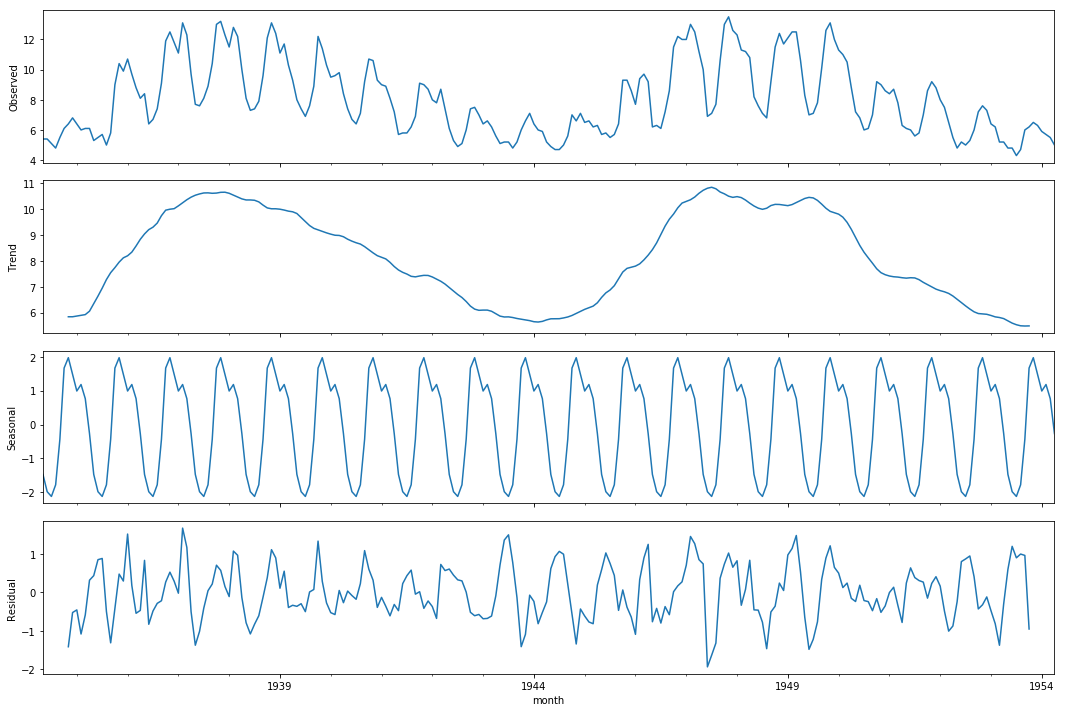

In [30]:
figsize(15,10)
sm.tsa.seasonal_decompose(data.rad_freq).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.rad_freq)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: -0.363429
Критерий Дики-Фуллера: p=0.044311


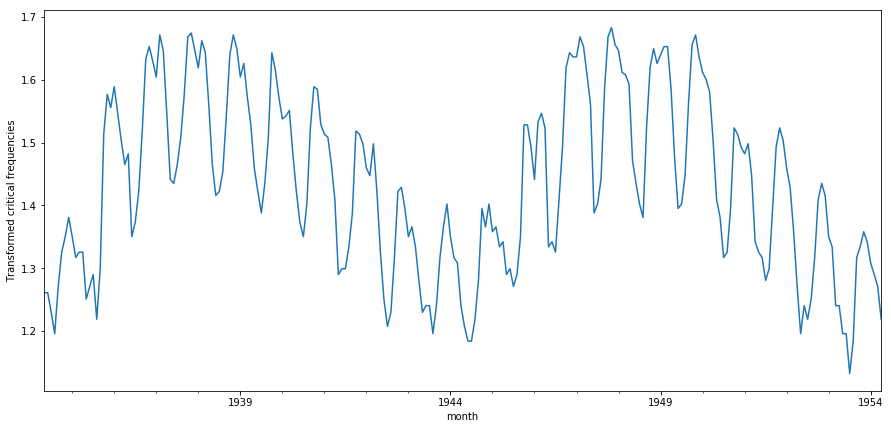

In [4]:
data['freq_box'], lmbda = stats.boxcox(data.rad_freq)
figsize(15,7)
data.freq_box.plot()
plt.ylabel(u'Transformed critical frequencies')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.freq_box)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности (после проведения преобразования Бокса-Кокса), но нужно еще убрать двойную сезонность.

У этого ряда одна сезонность периодом 12 месяцев, а другая 10 лет(120 месяцев). Но если есть две сезонности с периодами p1, p2, то это одна сезонность с периодом НОК(p1,p2).
НОК(12,120) = 120
Поэтому продифференцируем ряд с лагом 120.

Критерий Дики-Фуллера: p=0.000353


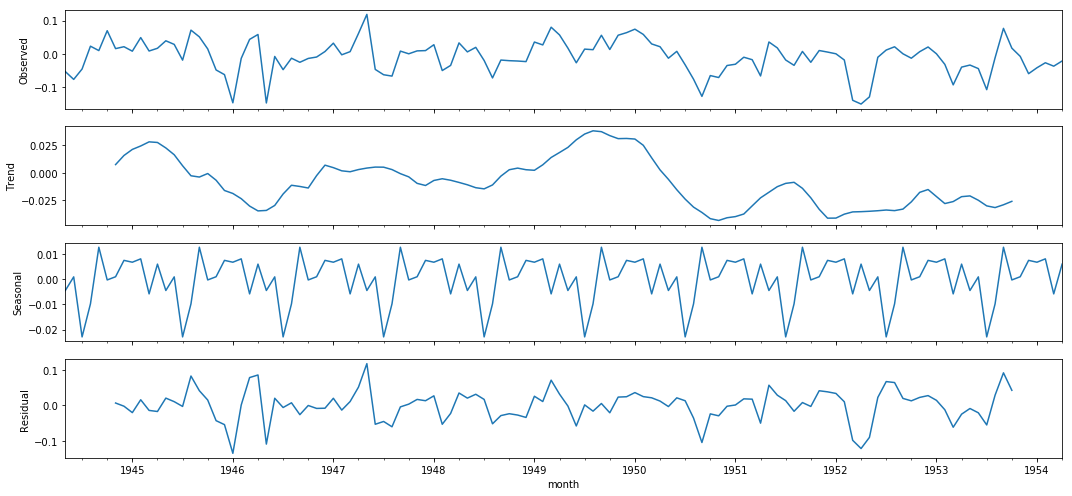

In [75]:
data['freq_box_diff'] = data.freq_box - data.freq_box.shift(120)
sm.tsa.seasonal_decompose(data.freq_box_diff[120:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.freq_box_diff[120:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, при этом pvalue значительно уменьшилось, больше уверенности в стационарности ряда. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


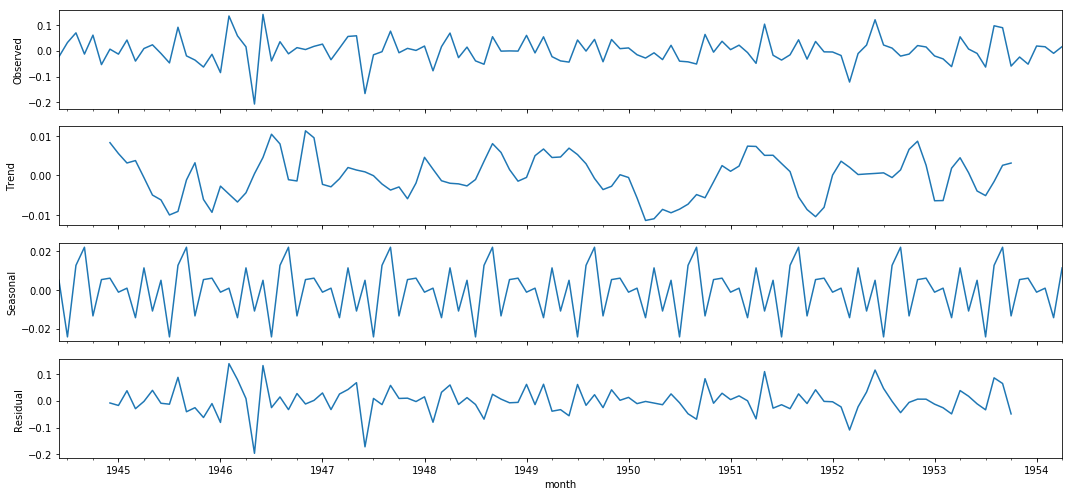

In [76]:
data['freq_box_diff2'] = data.freq_box_diff - data.freq_box_diff.shift(1)
sm.tsa.seasonal_decompose(data.freq_box_diff2[121:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.freq_box_diff2[121:])[1])

In [73]:
sm.tsa.stattools.adfuller(data.freq_box_diff2[121:])[1]

1.7679894077103386e-11

Критерий Дики-Фуллера отвергает гипотезу нестационарности и pvalue стало нулевым (почти). 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

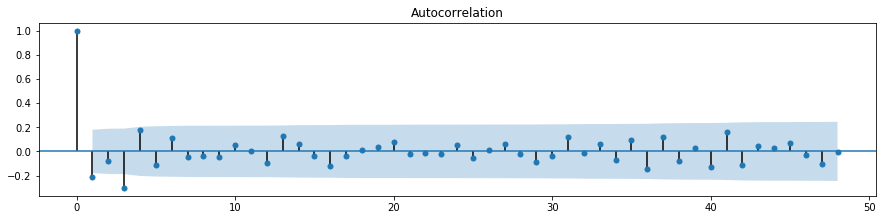

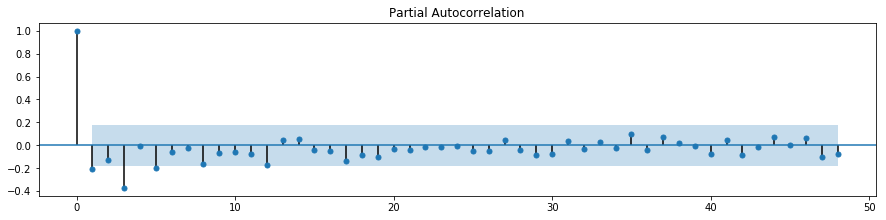

In [78]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.freq_box_diff2[121:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.freq_box_diff2[121:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [98]:
ps = range(0, 3)
d=1
qs = range(0, 3)
Ps = range(0, 3)
D=1
Qs = range(0, 3)

In [99]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

81

In [100]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.freq_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 120)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 0, 2)
wrong parameters: (0, 0, 1, 0)
wrong parameters: (0, 0, 1, 1)
wrong parameters: (0, 0, 1, 2)
wrong parameters: (0, 0, 2, 0)
wrong parameters: (0, 0, 2, 1)
wrong parameters: (0, 0, 2, 2)
wrong parameters: (0, 1, 0, 1)
wrong parameters: (0, 1, 0, 2)
wrong parameters: (0, 1, 1, 0)
wrong parameters: (0, 1, 1, 1)
wrong parameters: (0, 1, 1, 2)
wrong parameters: (0, 1, 2, 0)
wrong parameters: (0, 1, 2, 1)
wrong parameters: (0, 1, 2, 2)
wrong parameters: (0, 2, 0, 1)
wrong parameters: (0, 2, 0, 2)
wrong parameters: (0, 2, 1, 0)
wrong parameters: (0, 2, 1, 1)
wrong parameters: (0, 2, 1, 2)
wrong parameters: (0, 2, 2, 0)
wrong parameters: (0, 2, 2, 1)
wrong parameters: (0, 2, 2, 2)
wrong parameters: (1, 0, 0, 1)
wrong parameters: (1, 0, 0, 2)
wrong parameters: (1, 0, 1, 0)
wrong parameters: (1, 0, 1, 1)
wrong parameters: (1, 0, 1, 2)
wrong parameters: (1, 0, 2, 0)
wrong parameters: (1, 0, 2, 1)
wrong pa

In [101]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters         aic
5  (2, 2, 0, 0) -394.216795
3  (1, 2, 0, 0) -394.191029
1  (0, 2, 0, 0) -389.703322
0  (0, 1, 0, 0) -376.300510
4  (2, 0, 0, 0) -372.030158


Лучшая модель:

In [102]:
print(best_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:                            freq_box   No. Observations:                  240
Model:             SARIMAX(2, 1, 2)x(0, 1, 0, 120)   Log Likelihood                 202.108
Date:                             Wed, 13 Dec 2017   AIC                           -394.217
Time:                                     19:16:31   BIC                           -376.814
Sample:                                 05-01-1934   HQIC                          -387.205
                                      - 04-01-1954                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3646      0.193     -1.889      0.059      -0.743       0.014
ar.L2          0.4823      

Её остатки:

Критерий Стьюдента: p=0.720308
Критерий Дики-Фуллера: p=0.000000


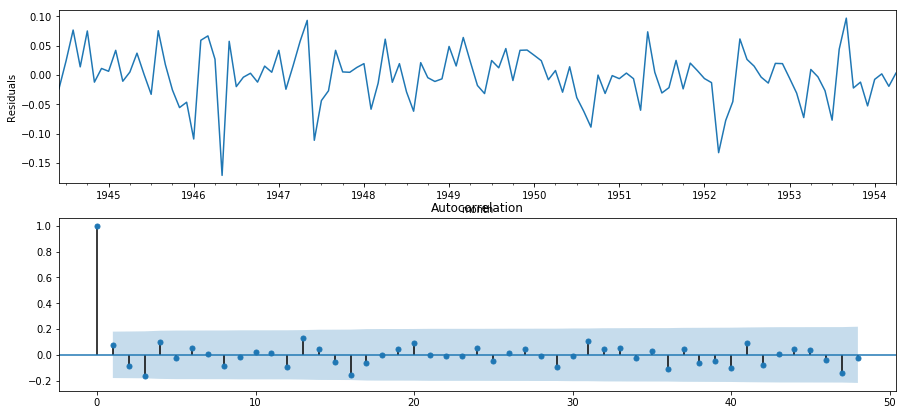

In [103]:
plt.subplot(211)
best_model.resid[121:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[121:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[121:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[121:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

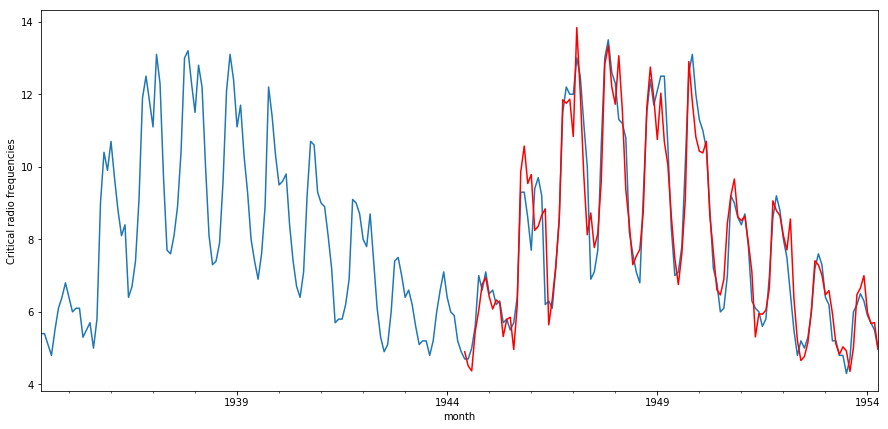

In [104]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
data.rad_freq.plot()
data.model[121:].plot(color='r')
plt.ylabel('Critical radio frequencies')
pylab.show()

### Прогноз

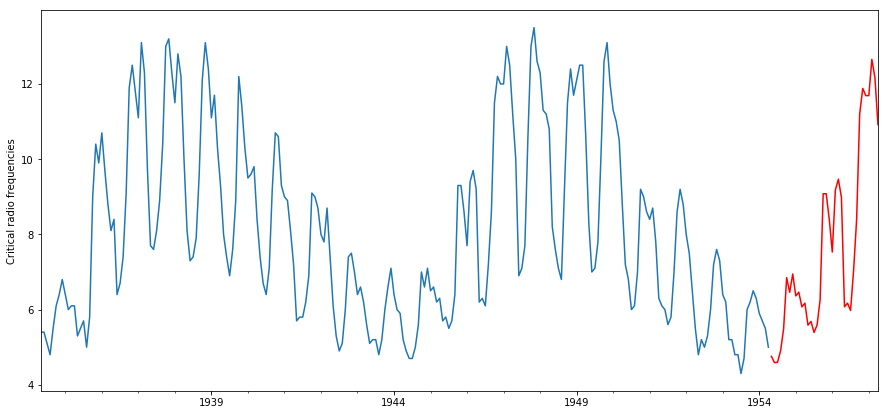

In [113]:

data2 = data[['rad_freq']]
date_list = [datetime.datetime.strptime("1954-05-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=240, end=275),lmbda)

plt.figure(figsize(15,7))
data2.rad_freq.plot()
data2.forecast.plot(color='r')
plt.ylabel('Critical radio frequencies')
pylab.show()